In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from tifffile import imwrite
from PIL import Image
from tqdm import tqdm
from copy import deepcopy
import json

In [2]:
biopsy_id = "0011546 - X15_0"

In [3]:
f = [e for e in os.listdir("../tmp_gloms_to_show") if biopsy_id in e][0]
adata = sc.read(f"../tmp_gloms_to_show/{f}")

In [4]:
adata_pg = sc.read("/data/projects/zeba/MY_PROJECTS/240130_Xenium_ANCA_SLE_GBM/xenium-cgn/notebooks_zs/"+\
                   "02_PeriglomDefinition/output_dataobjects/Slides_ALL_PeriglomDefined_withuns.h5ad")

In [5]:
adata.obs = adata_pg[adata.obs.index].obs.copy()

In [7]:
# for glom in adata.obs["polygon_flags"].unique():
#     sc.pl.spatial(adata[adata.obs.polygon_flags==glom], library_id="0011546", img_key="he_LEVEL1_cropped",
#              s=5, title=glom)

In [11]:
[e for e in adata.obs["polygon_flags"].unique() if "1_0011546_Cntrl_X10" in e]

['1_0011546_Cntrl_X10',
 '11_0011546_Cntrl_X10',
 '11_0011546_Cntrl_X10,18_0011546_Cntrl_X10',
 '21_0011546_Cntrl_X10',
 '18_0011546_Cntrl_X10,21_0011546_Cntrl_X10',
 '21_0011546_Cntrl_X10,27_0011546_Cntrl_X10',
 '31_0011546_Cntrl_X10',
 '21_0011546_Cntrl_X10,31_0011546_Cntrl_X10',
 '31_0011546_Cntrl_X10,32_0011546_Cntrl_X10',
 '41_0011546_Cntrl_X10',
 '41_0011546_Cntrl_X10,44_0011546_Cntrl_X10',
 '41_0011546_Cntrl_X10,46_0011546_Cntrl_X10',
 '51_0011546_Cntrl_X10',
 '60_0011546_Cntrl_X10,61_0011546_Cntrl_X10',
 '61_0011546_Cntrl_X10']

In [12]:
keep_gloms = ["1_0011546_Cntrl_X10"]

In [13]:
sub_1 = adata[adata.obs.polygon_flags.isin(keep_gloms)]

In [14]:
# for glom in adata.obs["polygon_flags"].unique():
#     sc.pl.spatial(adata[adata.obs.polygon_flags==glom], library_id="0011546", img_key="he_LEVEL1_cropped",
#              s=5, title=glom)

In [15]:
sub_2 = adata_pg[sub_1.obs.index]

In [16]:
adata_all = sc.read("../xenium_outs/merged_processed_cleaned.h5ad")

In [17]:
LEVEL = 1

In [18]:
adata_all = adata_all[adata_all.obs["Biopsy_ID"].astype(str)!="nan"]

In [19]:
for sample in tqdm(adata_all.obs.Biopsy_ID.unique()):
    if sample==biopsy_id[:-2]:
        if str(sample)!="nan":
            i=0
            sub = adata_all[adata_all.obs.Biopsy_ID==sample]
            ID = sub.obs.Slide_ID.unique()[0]
            scale_factor = sub.uns["spatial"][ID]["scalefactors"][f"tissue_dapi_LEVEL{LEVEL}_scalef"]
            ylim=(sub.obsm["spatial"][:,1].min()-1, sub.obsm["spatial"][:,1].max()+1)
            xlim=(sub.obsm["spatial"][:,0].min()-1, sub.obsm["spatial"][:,0].max()+1)
            ylim = tuple(np.array(ylim)*scale_factor)
            xlim = tuple(np.array(xlim)*scale_factor)
        
            img = sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"]
            cur_coords = np.concatenate([xlim, ylim])
            img_cropped = img[int(cur_coords[2]): int(np.ceil(cur_coords[3])),\
                             int(cur_coords[0]): int(np.ceil(cur_coords[1]))]
        
            sub.uns["spatial"][ID]["images"][f"dapi_LEVEL{LEVEL}"+"_cropped"] = img_cropped
            sub.uns["spatial"][ID]["scalefactors"]["tissue_dapi_LEVEL{LEVEL}_cropped_scalef"] = 1
        
            sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cur_coords[0])
            sub.obsm["spatial"][:,1] = sub.obsm["spatial"][:,1]*scale_factor-int(cur_coords[2])

  0%|          | 0/151 [00:00<?, ?it/s]/tmp/ipykernel_22795/753129904.py:21: ImplicitModificationWarning: Trying to modify attribute `.obsm` of view, initializing view as actual.
  sub.obsm["spatial"][:,0] = sub.obsm["spatial"][:,0]*scale_factor-int(cur_coords[0])
100%|██████████| 151/151 [00:12<00:00, 11.63it/s]


In [20]:
p_baysor = "/data/projects/robin/segmentation/outputs/output-XETG00088__0011546__Region_1__20240130__161548"

In [21]:
import json

with open(os.path.join(p_baysor, "segmentation_polygons.json")) as f:
    cells_baysor = json.load(f)

In [22]:
import pandas as pd
tmp_cells_baysor = pd.json_normalize(cells_baysor["geometries"])

In [23]:
cells = [int(e.split("-")[-1]) for e in sub_1.obs.index]

In [24]:
tmp_cells_baysor = tmp_cells_baysor[tmp_cells_baysor.cell.isin(cells)]

In [25]:
ds = {}
for i in tqdm(range(tmp_cells_baysor.shape[0])):
    ds[i] = pd.DataFrame(tmp_cells_baysor.iloc[i,0][0])

100%|██████████| 564/564 [00:00<00:00, 9098.66it/s]


In [26]:
df_cells_baysor = pd.concat(ds)

In [27]:
df_cells_baysor = df_cells_baysor.reset_index()
df_cells_baysor = df_cells_baysor.set_index("level_0").iloc[:,1:]

In [28]:
df_cells_baysor.columns = ["vertex_x", "vertex_y"]

In [29]:
fov = df_cells_baysor.copy()

In [30]:
color_dict = dict(zip(sub_2.obs.celltype_l1.cat.categories, sub_2.uns["celltype_l1_colors"]))

In [31]:
ds = {}
for i in tqdm(range(tmp_cells_baysor.shape[0])):
    ds[i] = sub_2.obs.loc[[cell for cell in sub_2.obs.index if str(tmp_cells_baysor.iloc[i]["cell"]) in cell][0], "celltype_l1"]

100%|██████████| 564/564 [00:13<00:00, 41.27it/s]


In [32]:
colors = {}
for i in ds:
    colors[i] = color_dict[ds[i]]

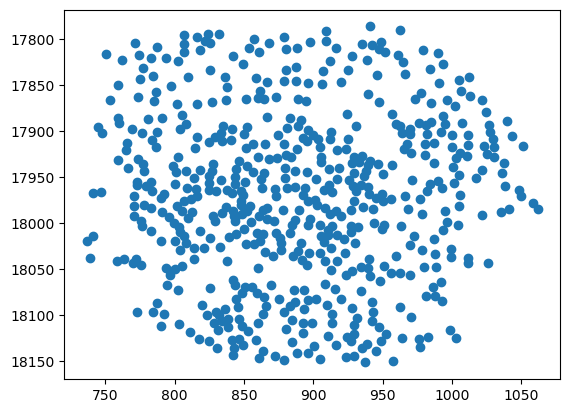

In [33]:
ax = plt.subplot(111)
xs, ys = sub_2.obsm["spatial"][:,0], sub_2.obsm["spatial"][:,1]
plt.scatter(xs, ys)
ax.invert_yaxis()

In [58]:
sub_3 = sub_2[(sub_2.obsm["spatial"][:,0]<=1050)&(sub_2.obsm["spatial"][:,0]>=700)]
sub_3 = sub_3[(sub_3.obsm["spatial"][:,1]<=18150)&(sub_3.obsm["spatial"][:,1]>=17800)]

In [59]:
import pandas as pd
tmp_cells_baysor = pd.json_normalize(cells_baysor["geometries"])

In [60]:
cells = [int(e.split("-")[-1]) for e in sub_3.obs.index]

In [61]:
tmp_cells_baysor = tmp_cells_baysor[tmp_cells_baysor.cell.isin(cells)]

In [62]:
ds = {}
for i in tqdm(range(tmp_cells_baysor.shape[0])):
    ds[i] = pd.DataFrame(tmp_cells_baysor.iloc[i,0][0])

100%|██████████| 550/550 [00:00<00:00, 5306.44it/s]


In [63]:
df_cells_baysor = pd.concat(ds)

In [64]:
df_cells_baysor = df_cells_baysor.reset_index()
df_cells_baysor = df_cells_baysor.set_index("level_0").iloc[:,1:]

In [65]:
df_cells_baysor.columns = ["vertex_x", "vertex_y"]

In [66]:
fov = df_cells_baysor.copy()

In [67]:
color_dict = dict(zip(sub_2.obs.celltype_l1.cat.categories, sub_2.uns["celltype_l1_colors"]))

In [68]:
ds = {}
for i in tqdm(range(tmp_cells_baysor.shape[0])):
    ds[i] = sub_3.obs.loc[[cell for cell in sub_3.obs.index if str(tmp_cells_baysor.iloc[i]["cell"]) in cell][0], "celltype_l1"]

100%|██████████| 550/550 [00:13<00:00, 39.39it/s]


In [69]:
colors = {}
for i in ds:
    colors[i] = color_dict[ds[i]]

100%|██████████| 550/550 [00:00<00:00, 1067.14it/s]


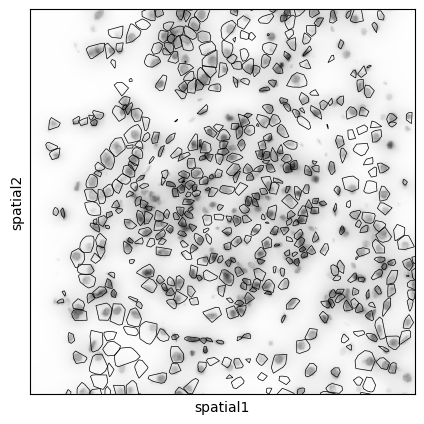

In [71]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
plt.figure(figsize=(5,5))
ax=plt.subplot(1,1,1)
n_cells = 0

sc.pl.spatial(sub_3, color=None, library_id="0011546", img_key="dapi_LEVEL1",
             s=5, ax=ax, show=False, title="")

n_cells = 0
all_x, all_y = [], []

for cell_idx in tqdm(fov.index.unique()):
    n_cells += 1
    if fov.loc[cell_idx].shape[0] > 3:
        cell = fov.loc[cell_idx]
        points = np.array(cell)
        hull = ConvexHull(np.array(cell))
        
        all_x.extend(points[:, 0])
        all_y.extend(points[:, 1])
        
        polygon = Polygon(points[hull.vertices], 
                          facecolor="none",
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5)
        
        ax.add_patch(polygon)
plt.xlim(720, 1030)
plt.ylim(17820, 18130)
plt.xticks([],[])
plt.yticks([],[])

plt.savefig("figures/ctrl_x15_segmentated_cells.pdf", bbox_inches="tight")
plt.show()

100%|██████████| 550/550 [00:00<00:00, 1132.91it/s]


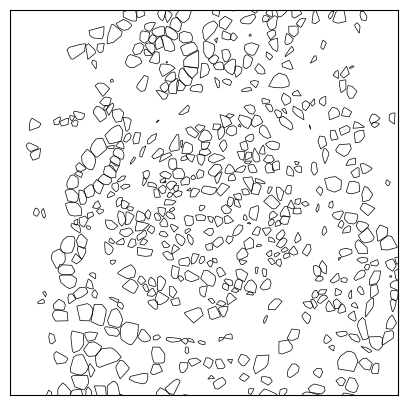

In [72]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
plt.figure(figsize=(5,5))
ax=plt.subplot(1,1,1)
n_cells = 0

# sc.pl.spatial(sub_3, color=None, library_id="0011546", img_key="dapi_LEVEL1",
#              s=5, ax=ax, show=False, title="celltype_l1")

n_cells = 0
all_x, all_y = [], []

for cell_idx in tqdm(fov.index.unique()):
    n_cells += 1
    if fov.loc[cell_idx].shape[0] > 3:
        cell = fov.loc[cell_idx]
        points = np.array(cell)
        hull = ConvexHull(np.array(cell))
        
        all_x.extend(points[:, 0])
        all_y.extend(points[:, 1])
        
        polygon = Polygon(points[hull.vertices], 
                          facecolor="none",
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5)
        
        ax.add_patch(polygon)
plt.xlim(720, 1030)
plt.ylim(17820, 18130)
plt.xticks([],[])
plt.yticks([],[])

plt.savefig("figures/ctrl_x15_segmentated_cells_without_DAPI.pdf", bbox_inches="tight")
plt.show()

In [76]:
import json

tr_baysor = pd.read_csv(os.path.join(p_baysor, "segmentation.csv"), index_col=0)

In [77]:
molecules = ["PODXL", "PDGFRB", "CLDN1", "COL1A1", "S100A9", "MS4A1", "CD3"]

In [78]:
tr_baysor.gene.replace({"CD3A": "CD3", "CD3D": "CD3", "CD3E": "CD3", "CD3G": "CD3"}, inplace=True)

In [79]:
tr_bayor = tr_baysor[tr_baysor.gene.isin(molecules)]

In [80]:
import seaborn as sns
molecule_colormap = dict(zip(molecules, list(sns.color_palette("colorblind", len(molecules)).as_hex())))

In [81]:
molecule_colormap = {
    "PODXL": "#FF0000",
    "PDGFRB": "#0000FF",
    "CLDN1": "#00FF00",
    "COL1A1": "#FF00FF",
    "S100A9": "#FFD700",
    "MS4A1": "#8B008B",
    "CD3": "#FF8C00"
}

In [82]:
tr_baysor["cell_id"] = [f"cell_{e}" for e in tr_baysor.cell.tolist()]

In [83]:
sub_tr_baysor = tr_baysor[tr_baysor.cell_id.isin(sub_3.obs.index)]

100%|██████████| 550/550 [00:00<00:00, 1312.61it/s]
/tmp/ipykernel_22795/2346126323.py:40: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in range(len(legend.legendHandles)):
/tmp/ipykernel_22795/2346126323.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[i]._sizes = [20]


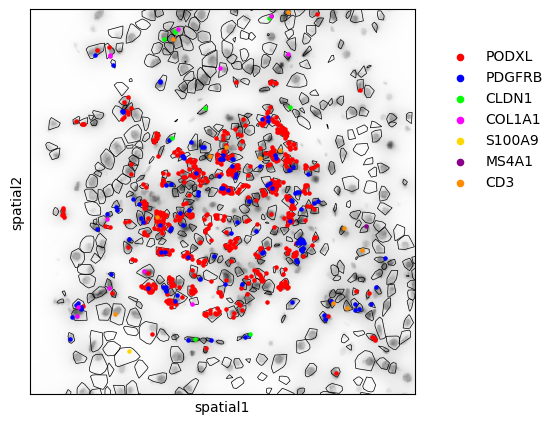

In [84]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
plt.figure(figsize=(5,5))
ax=plt.subplot(1,1,1)
n_cells = 0

sc.pl.spatial(sub_3, color=None, library_id="0011546", img_key="dapi_LEVEL1",
             s=5, ax=ax, show=False, title="")

n_cells = 0
all_x, all_y = [], [] 

for cell_idx in tqdm(fov.index.unique()):
    n_cells += 1
    if fov.loc[cell_idx].shape[0] > 3:
        cell = fov.loc[cell_idx]
        points = np.array(cell)
        hull = ConvexHull(np.array(cell))
        
        all_x.extend(points[:, 0])
        all_y.extend(points[:, 1])
        
        polygon = Polygon(points[hull.vertices], 
                          facecolor="none",
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5)
        
        ax.add_patch(polygon)

for molecule in molecules:
    sub_tr_baysor1 = sub_tr_baysor[sub_tr_baysor["gene"]==molecule]
    x, y = sub_tr_baysor1["x"].tolist(), sub_tr_baysor1["y"].tolist()
    ax.scatter(x, y, color=molecule_colormap[molecule], label=molecule, s=5)
legend = plt.legend(bbox_to_anchor=(1.05,0.5), frameon=False)
for i in range(len(legend.legendHandles)):
    legend.legendHandles[i]._sizes = [20]
plt.xlim(720, 1030)
plt.ylim(17820, 18130)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig("figures/ctrl_x15_segmentated_cells_transcripts.pdf", bbox_inches="tight")

plt.show()

100%|██████████| 550/550 [00:00<00:00, 842.71it/s] 
/tmp/ipykernel_22795/102796497.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i in range(len(legend.legendHandles)):
/tmp/ipykernel_22795/102796497.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  legend.legendHandles[i]._sizes = [20]


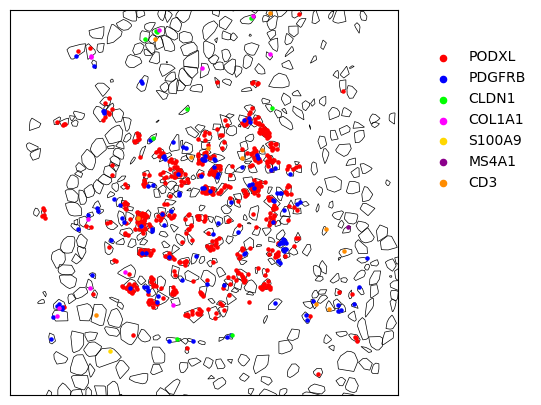

In [85]:
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
plt.figure(figsize=(5,5))
ax=plt.subplot(1,1,1)
n_cells = 0

n_cells = 0
all_x, all_y = [], [] 

for cell_idx in tqdm(fov.index.unique()):
    n_cells += 1
    if fov.loc[cell_idx].shape[0] > 3:
        cell = fov.loc[cell_idx]
        points = np.array(cell)
        hull = ConvexHull(np.array(cell))
        
        all_x.extend(points[:, 0])
        all_y.extend(points[:, 1])
        
        polygon = Polygon(points[hull.vertices], 
                          facecolor="none",
                          edgecolor="black",
                          alpha=1,
                          linewidth=0.5)
        
        ax.add_patch(polygon)

for molecule in molecules:
    sub_tr_baysor1 = sub_tr_baysor[sub_tr_baysor["gene"]==molecule]
    x, y = sub_tr_baysor1["x"].tolist(), sub_tr_baysor1["y"].tolist()
    ax.scatter(x, y, color=molecule_colormap[molecule], label=molecule, s=5)
legend = plt.legend(bbox_to_anchor=(1.05,0.5), frameon=False)
for i in range(len(legend.legendHandles)):
    legend.legendHandles[i]._sizes = [20]
plt.xlim(720, 1030)
plt.ylim(17820, 18130)
plt.xticks([],[])
plt.yticks([],[])
plt.savefig("figures/ctrl_x15_segmentated_cells_transcripts_without_DAPI.pdf", bbox_inches="tight")

plt.show()